In [1]:

from sklearn import feature_extraction 
stop_words = feature_extraction.text.ENGLISH_STOP_WORDS
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import nltk
from gensim.models import Word2Vec
from textblob import TextBlob
import re

def preprocess(text):
  text = text.lower() #lowercase
  text = re.sub(r'[^\w\s]', '', text) #remove punctuations
  text = re.sub(r'\d+', '', text) #remove numbers
  text = " ".join(text.split()) #stripWhitespace
  text = text.split()
  text = [x for x in text if x not in stop_words] #remove stopwords
  text = [x for x in text if x not in ["dr", "doctor"]] #remove task specific stopwords
  text = " ".join(text)
  # stemmer_ps = PorterStemmer()  
  # text = [stemmer_ps.stem(word) for word in text.split()] #stemming
  # text = " ".join(text)
  # lemmatizer = WordNetLemmatizer()
  # text = [lemmatizer.lemmatize(word) for word in text.split()]  #lemmatization
  # text = " ".join(text)
  return(text)

# Load the dataset
import pandas as pd
data = pd.read_csv('nykaa_data.csv')

data['review_processed']=data['review_text'].apply(lambda x:preprocess(str(x)))
data['review_processed']=data['review_processed'].apply(lambda x:x.split())

# Convert 'Date' column to datetime
data['review_date'] = pd.to_datetime(data['review_date'], errors='coerce')
data['Month'] = data['review_date'].dt.to_period('M')  # Extract month for trend analysis

# Replace infinite values with NaN
data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Ensure the dataset has the expected columns
data.head()

,product_id,brand_name,review_id,review_title,review_text,author,review_date,review_rating,is_a_buyer,pro_user,review_label,product_title,mrp,price,product_rating,product_rating_count,product_tags,product_url,review_processed,Month
0,781070,Olay,16752142,Worth buying 50g one,Works as it claims. Could see the difference f...,Ashton Dsouza,2021-01-23 15:17:18,5.0,True,False,Verified Buyer,Olay Ultra Lightweight Moisturiser: Luminous W...,1999,1599,4.1,43,NaN,https://www.nykaa.com/olay-ultra-lightweight-m...,"[works, claims, difference, day, use, olay, cl...",2021-01
1,781070,Olay,14682550,Best cream to start ur day,It does what it claims . Best thing is it smoo...,Amrit Neelam,2020-09-07 15:30:42,5.0,True,False,Verified Buyer,Olay Ultra Lightweight Moisturiser: Luminous W...,1999,1599,4.1,43,NaN,https://www.nykaa.com/olay-ultra-lightweight-m...,"[does, claims, best, thing, smoothens, ur, ski...",2020-09
2,781070,Olay,15618995,perfect for summers dry for winters,I have been using this product for months now....,Sanchi Gupta,2020-11-13 12:24:14,4.0,True,False,Verified Buyer,Olay Ultra Lightweight Moisturiser: Luminous W...,1999,1599,4.1,43,NaN,https://www.nykaa.com/olay-ultra-lightweight-m...,"[using, product, months, perfect, combination,...",2020-11
3,781070,Olay,13474509,Not a moisturizer,"i have an oily skin, while this whip acts as a...",Ruchi Shah,2020-06-14 11:56:50,3.0,True,False,Verified Buyer,Olay Ultra Lightweight Moisturiser: Luminous W...,1999,1599,4.1,43,NaN,https://www.nykaa.com/olay-ultra-lightweight-m...,"[oily, skin, whip, acts, great, base, primer, ...",2020-06
4,781070,Olay,16338982,Average,It's not that good. Please refresh try for oth...,Sukanya Sarkar,2020-12-22 15:24:35,2.0,True,False,Verified Buyer,Olay Ultra Lightweight Moisturiser: Luminous W...,1999,1599,4.1,43,NaN,https://www.nykaa.com/olay-ultra-lightweight-m...,"[good, refresh, try, products]",2020-12


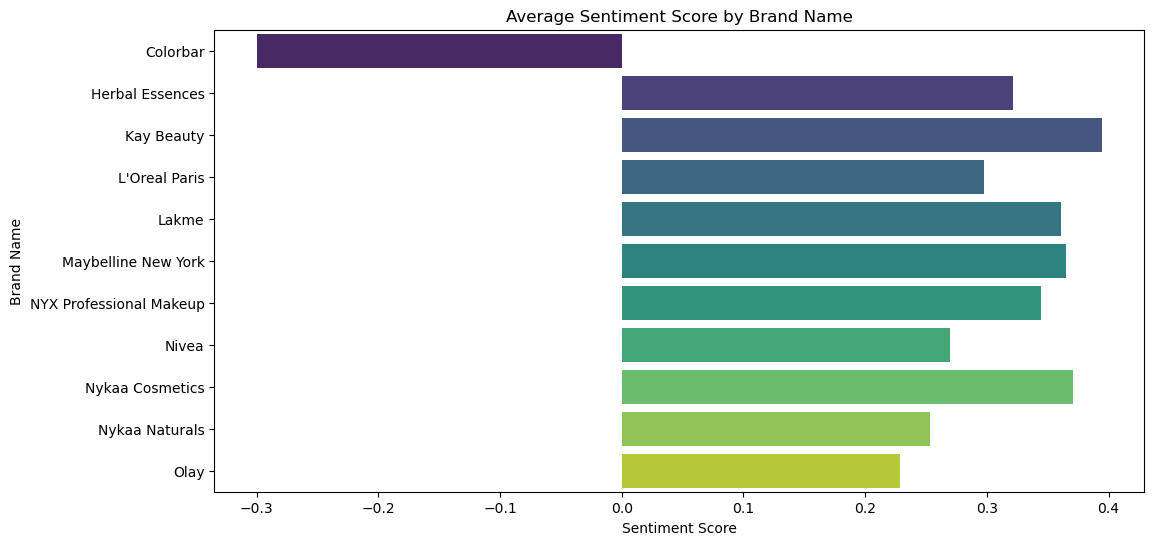

In [2]:
# -------------------------
# 1️⃣ BRAND-WISE SENTIMENT ANALYSIS
# -------------------------

# Check if 'Sentiment_Score' exists, else create it using TextBlob
if 'Sentiment_Score' not in data.columns:
    data['Sentiment_Score'] = data['review_text'].astype(str).apply(lambda x: TextBlob(x).sentiment.polarity)

data = data.dropna(subset=['Sentiment_Score'])    
    
# Aggregate sentiment scores by brand
brand_sentiment = data.groupby('brand_name', as_index=False)['Sentiment_Score'].mean()

# Visualization
plt.figure(figsize=(12, 6))
sns.barplot(x='Sentiment_Score', y='brand_name', data=brand_sentiment, palette='viridis')
plt.title("Average Sentiment Score by Brand Name")
plt.xlabel("Sentiment Score")
plt.ylabel("Brand Name")
plt.show()

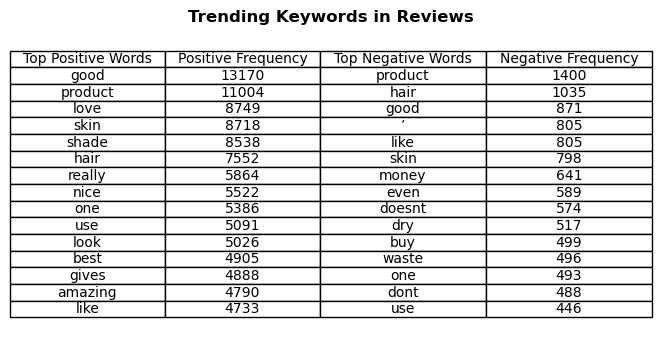

In [3]:
# -------------------------
# 2️⃣ TRENDING KEYWORDS IN HIGH VS LOW-RATED PRODUCTS
# -------------------------

# Ensure stop words are set up properly
stop_words = set(stopwords.words('english'))

# Function to clean and tokenize text efficiently
def clean_text_fast(text):
    text = str(text).lower().translate(str.maketrans('', '', string.punctuation))
    return [word for word in word_tokenize(text) if word not in stop_words]

# Filter reviews into positive and negative categories
positive_reviews = data.loc[data['review_rating'] >= 4, 'review_text'].dropna()
negative_reviews = data.loc[data['review_rating'] <= 2, 'review_text'].dropna()

# Process all positive and negative reviews at once
positive_words = []
negative_words = []

for review in positive_reviews:
    positive_words.extend(clean_text_fast(review))

for review in negative_reviews:
    negative_words.extend(clean_text_fast(review))

# Get the 15 most common words in each category
top_positive_words = Counter(positive_words).most_common(15)
top_negative_words = Counter(negative_words).most_common(15)

# Convert to DataFrame for cleaner formatting
df_keywords = pd.DataFrame({
    "Top Positive Words": [word[0] for word in top_positive_words],
    "Positive Frequency": [word[1] for word in top_positive_words],
    "Top Negative Words": [word[0] for word in top_negative_words],
    "Negative Frequency": [word[1] for word in top_negative_words]
})


import matplotlib.pyplot as plt
import pandas as pd

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 4))
ax.axis('tight')
ax.axis('off')

# Create the table
table_data = df_keywords.values.tolist()
columns = df_keywords.columns.tolist()
table = ax.table(cellText=table_data, colLabels=columns, cellLoc='center', loc='center')

# Adjust table appearance
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width([0, 1, 2, 3])

plt.title("Trending Keywords in Reviews", fontsize=12, fontweight="bold")
plt.show()


/Users/kiranmayi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/kiranmayi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


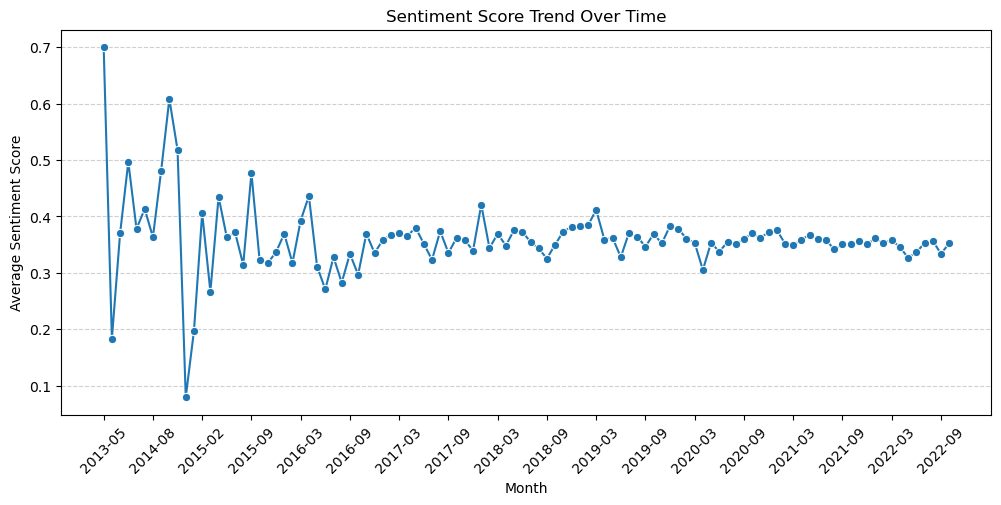

In [6]:
# -------------------------
# 3️⃣ SENTIMENT TRENDS OVER TIME
# -------------------------

# Ensure 'Sentiment_Score' is numeric
data['Sentiment_Score'] = pd.to_numeric(data['Sentiment_Score'], errors='coerce')

# Replace infinite values with NaN
data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop NaN values
time_trend = data.dropna(subset=['Sentiment_Score'])

# Aggregate sentiment score over time
time_trend = time_trend.groupby('Month', as_index=False)['Sentiment_Score'].mean()

# Convert 'Month' to string to avoid plotting issues
time_trend['Month'] = time_trend['Month'].astype(str)

# Visualization
plt.figure(figsize=(12, 5))
sns.lineplot(x='Month', y='Sentiment_Score', data=time_trend, marker='o')

# Reduce the number of x-axis labels
plt.xticks(ticks=np.arange(0, len(time_trend), step=6), rotation=45)  # Show every 6th month

plt.title("Sentiment Score Trend Over Time")
plt.xlabel("Month")
plt.ylabel("Average Sentiment Score")
plt.grid(axis='y', linestyle='--', alpha=0.6)  # Add horizontal grid lines for readability
plt.show()


In [7]:
# -------------------------
# 4️⃣ SENTIMENT SCORE PER PRODUCT
# -------------------------

product_sentiment = data.groupby('product_title')['Sentiment_Score'].mean().reset_index()
product_sentiment = product_sentiment.sort_values(by='Sentiment_Score', ascending=False)

print("\nTop 10 Best-Rated Products by Sentiment Score:")
print(product_sentiment.head(10))


Top 10 Best-Rated Products by Sentiment Score:
                                         product_title  Sentiment_Score
291  The Ultimate Nude Duo - Kay Beauty Long Stay M...         1.000000
140  Nykaa All Day Matte Long Wear Foundation + Com...         1.000000
259   Nykaa So Matte! Mini Lipstick - 45 M Dirty Peach         1.000000
166  Nykaa Cosmetics Puckers On With Matte To Last ...         0.910000
157  Nykaa Cosmetics Breathable Nail Enamel Set Of ...         0.800000
43                        Kay Beauty Lip & Cheek Combo         0.754583
158  Nykaa Cosmetics Eyes On Me ! 4 In 1 Quad Eyesh...         0.700000
56   Kay Beauty Pastel Crush Nail Enamel Combo- Ten...         0.700000
51   Kay Beauty Matteinee Matte Lip Crayon Lipstick...         0.700000
55        Kay Beauty Paint Your Mood Nail Enamel Combo         0.683333


In [9]:
# -------------------------
# 5️⃣ FACTORS AFFECTING RATINGS (WORD CORRELATION ANALYSIS)
# -------------------------

# Ensure 'review_text' is treated as a string and fill NaN values with empty strings
data['review_text'] = data['review_text'].fillna("").astype(str)

# Create a binary column for positive reviews (1 if rating >= 4, else 0)
data['Positive'] = np.where(data['review_rating'] >= 4, 1, 0)

# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features=500)

# Transform the review text instead of numerical ratings
X = vectorizer.fit_transform(data['review_text'])
y = data['Positive']

# Train Logistic Regression model
model = LogisticRegression()
model.fit(X, y)

# Get the most important words influencing positive and negative sentiment
feature_names = np.array(vectorizer.get_feature_names_out())
sorted_coef_index = model.coef_[0].argsort()

print("\nMost Negative Words:", feature_names[sorted_coef_index[:10]])
print("Most Positive Words:", feature_names[sorted_coef_index[-10:]])


Most Negative Words: ['worst' 'waste' 'disappointed' 'bad' 'smudges' 'didn' 'isn' 'doesn'
 'better' 'sticky']
Most Positive Words: ['lovely' 'superb' 'beautiful' 'easy' 'awesome' 'loved' 'amazing' 'best'
 'perfect' 'love']


In [11]:
# -------------------------
# 6️⃣ WORD2VEC MODEL (YOUR EXISTING IMPLEMENTATION)
# -------------------------


# Text preprocessing function
def preprocess(text):
    if not isinstance(text, str):  # Handle missing values
        return []
    
    text = text.lower()  # Lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    words = [word for word in word_tokenize(text) if word not in stop_words]  # Tokenize & remove stopwords
    
    return words

# Apply preprocessing to review text
data['Tokenized_Review'] = data['review_text'].apply(preprocess)

# Train Word2Vec model
word2vec_model = Word2Vec(
    sentences=data['Tokenized_Review'],
    vector_size=100, 
    window=5, 
    min_count=5, 
    workers=4, 
    sg=1,  # Skip-gram model
    epochs=50
)

# Example: Find similar words to "moisturizer"
if "moisturizer" in word2vec_model.wv:
    print("\nWords similar to 'moisturizer':", word2vec_model.wv.most_similar("moisturizer"))

# Save Word2Vec model
word2vec_model.save("word2vec_model.bin")

print("Word2Vec Model Training Completed & Saved.")



Words similar to 'moisturizer': [('moisturiser', 0.7122189998626709), ('sunscreen', 0.6726366281509399), ('foundation', 0.5947425961494446), ('cream', 0.5480473041534424), ('bb', 0.5470038056373596), ('mix', 0.5017359852790833), ('applying', 0.49895092844963074), ('primer', 0.49702730774879456), ('moisturizers', 0.49672892689704895), ('mattifying', 0.48493701219558716)]
Word2Vec Model Training Completed & Saved.


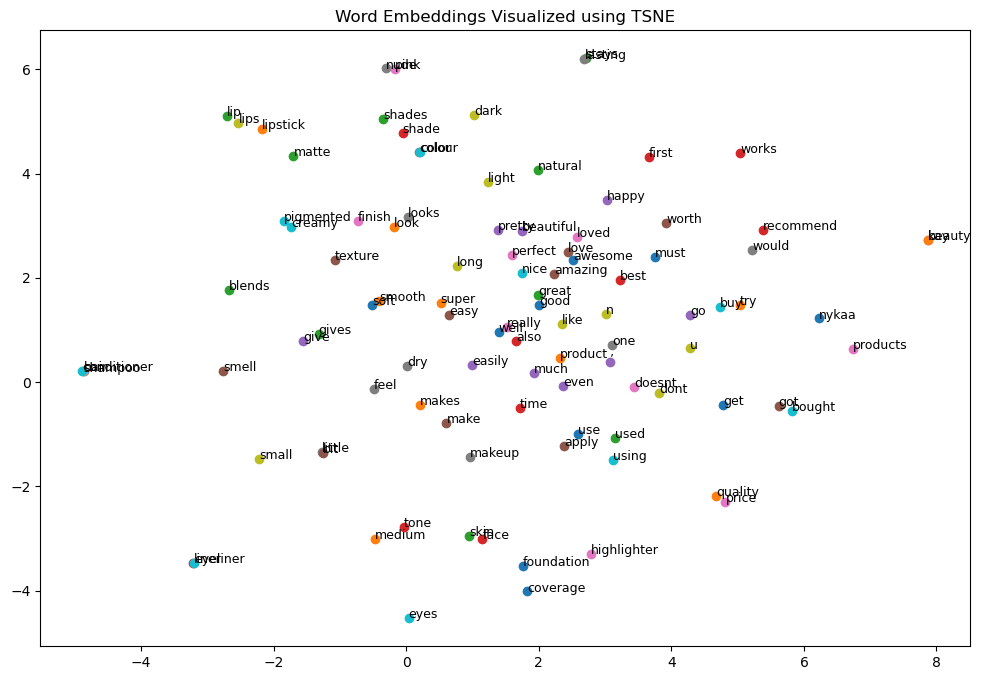

In [12]:
# -------------------------
# 7️⃣ VISUALIZATION: WORD EMBEDDINGS USING TSNE
# -------------------------

from sklearn.manifold import TSNE

# Select random words from the vocabulary
vocab = list(word2vec_model.wv.index_to_key)[:100]

# Get the word embeddings
word_vectors = np.array([word2vec_model.wv[word] for word in vocab])

# Apply TSNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
word_vectors_2d = tsne.fit_transform(word_vectors)

# Plot the words in 2D space
plt.figure(figsize=(12, 8))
for i, word in enumerate(vocab):
    plt.scatter(word_vectors_2d[i, 0], word_vectors_2d[i, 1])
    plt.annotate(word, xy=(word_vectors_2d[i, 0], word_vectors_2d[i, 1]), fontsize=9)

plt.title("Word Embeddings Visualized using TSNE")
plt.show()